In [108]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Weights and Biases
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [109]:
dataset_path = "dataset-augmented"
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

In [111]:
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range=0.3,
    shear_range=0.3,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3
)

In [112]:
data_gen_valid = ImageDataGenerator(rescale=1./255)
data_gen_test = ImageDataGenerator(rescale=1./255)

In [114]:
train_dataset = data_gen_train.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

valid_dataset = data_gen_valid.flow_from_directory(
    valid_dir,
    class_mode="categorical",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_dataset = data_gen_test.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 2675 images belonging to 6 classes.
Found 334 images belonging to 6 classes.
Found 335 images belonging to 6 classes.


In [116]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [117]:
for layer in base_model.layers[:100]:
    layer.trainable = False

# Unfreeze middle and top layers
for layer in base_model.layers[100:]:
    layer.trainable = True

In [118]:
mobnet_model = base_model.output
mobnet_model = layers.GlobalAveragePooling2D()(mobnet_model)
mobnet_model = layers.Dropout(0.5)(mobnet_model)
mobnet_model = layers.Dense(num_classes, activation='softmax')(mobnet_model)

model = Model(inputs=base_model.input, outputs=mobnet_model)

In [119]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [120]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [121]:
wandb.init(
    project="TrashNet - Classification",
    config={
        "architecture": "MobileNetV2",
        "learning_rate": 0.0001,
        "optimizer": "Adam",
        "loss_function": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "batch_size": batch_size,
        "epochs": 100,
    }
)

In [122]:
wandb_checkpoint = WandbModelCheckpoint(
    filepath='model/mobnet_model.keras',
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

callbacks = [
    wandb_checkpoint,
    reduce_lr,
    early_stopping,
    WandbMetricsLogger()
]

In [123]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/100


2025-03-12 20:30:55.524412: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1741811455.572814     384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811455.589311     384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811455.589818     384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811455.594761     384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811455.595428     384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811455.596044     384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811455.596764     384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811455.598020     384 gpu_

54/54 - 23s - loss: 1.4830 - accuracy: 0.4396 - val_loss: 1.1305 - val_accuracy: 0.5838 - lr: 1.0000e-04 - 23s/epoch - 430ms/step
Epoch 2/100


W0000 00:00:1741811476.004533     383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811476.005018     383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811476.005340     383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811476.005746     383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811476.006008     383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811476.006391     383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811476.007415     383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811476.007768     383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811476.007953     383 gp

54/54 - 15s - loss: 0.8180 - accuracy: 0.6964 - val_loss: 1.0479 - val_accuracy: 0.6198 - lr: 1.0000e-04 - 15s/epoch - 272ms/step
Epoch 3/100


W0000 00:00:1741811500.076212     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811500.076417     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811500.076614     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811500.076874     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811500.077101     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811500.077300     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811500.077543     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811500.077767     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811500.078661     386 gp

54/54 - 14s - loss: 0.6467 - accuracy: 0.7701 - val_loss: 1.1418 - val_accuracy: 0.6018 - lr: 1.0000e-04 - 14s/epoch - 266ms/step
Epoch 4/100


W0000 00:00:1741811504.767492     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811504.767704     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811504.767881     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811504.768140     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811504.768369     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811504.768575     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811504.768813     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811504.769035     386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811504.769462     386 gp

54/54 - 14s - loss: 0.5501 - accuracy: 0.7989 - val_loss: 1.2178 - val_accuracy: 0.5689 - lr: 1.0000e-04 - 14s/epoch - 259ms/step
Epoch 5/100


W0000 00:00:1741811518.007362     381 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811518.007566     381 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811518.007742     381 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811518.008004     381 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811518.008236     381 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811518.008446     381 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811518.009147     381 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811518.009373     381 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741811518.010341     381 gp

54/54 - 14s - loss: 0.4699 - accuracy: 0.8265 - val_loss: 1.4056 - val_accuracy: 0.5509 - lr: 1.0000e-04 - 14s/epoch - 264ms/step
Epoch 6/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.3912 - accuracy: 0.8606 - val_loss: 1.4367 - val_accuracy: 0.5689 - lr: 1.0000e-04 - 14s/epoch - 263ms/step
Epoch 7/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None



Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
54/54 - 14s - loss: 0.3553 - accuracy: 0.8710 - val_loss: 1.3836 - val_accuracy: 0.5958 - lr: 1.0000e-04 - 14s/epoch - 266ms/step
Epoch 8/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.3160 - accuracy: 0.8837 - val_loss: 1.1269 - val_accuracy: 0.6407 - lr: 5.0000e-05 - 14s/epoch - 267ms/step
Epoch 9/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.2934 - accuracy: 0.8920 - val_loss: 1.0045 - val_accuracy: 0.6796 - lr: 5.0000e-05 - 14s/epoch - 266ms/step
Epoch 10/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 15s - loss: 0.2603 - accuracy: 0.9118 - val_loss: 1.0401 - val_accuracy: 0.6826 - lr: 5.0000e-05 - 15s/epoch - 269ms/step
Epoch 11/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 15s - loss: 0.2393 - accuracy: 0.9166 - val_loss: 0.8831 - val_accuracy: 0.7126 - lr: 5.0000e-05 - 15s/epoch - 270ms/step
Epoch 12/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.2216 - accuracy: 0.9196 - val_loss: 0.7723 - val_accuracy: 0.7305 - lr: 5.0000e-05 - 14s/epoch - 266ms/step
Epoch 13/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.2393 - accuracy: 0.9234 - val_loss: 0.7403 - val_accuracy: 0.7605 - lr: 5.0000e-05 - 14s/epoch - 265ms/step
Epoch 14/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.2055 - accuracy: 0.9290 - val_loss: 0.5652 - val_accuracy: 0.8114 - lr: 5.0000e-05 - 14s/epoch - 264ms/step
Epoch 15/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.2030 - accuracy: 0.9312 - val_loss: 0.6041 - val_accuracy: 0.7904 - lr: 5.0000e-05 - 14s/epoch - 263ms/step
Epoch 16/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1950 - accuracy: 0.9364 - val_loss: 0.5289 - val_accuracy: 0.8293 - lr: 5.0000e-05 - 14s/epoch - 263ms/step
Epoch 17/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1666 - accuracy: 0.9454 - val_loss: 0.4973 - val_accuracy: 0.8353 - lr: 5.0000e-05 - 14s/epoch - 263ms/step
Epoch 18/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1715 - accuracy: 0.9417 - val_loss: 0.6107 - val_accuracy: 0.8024 - lr: 5.0000e-05 - 14s/epoch - 266ms/step
Epoch 19/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1740 - accuracy: 0.9357 - val_loss: 0.6255 - val_accuracy: 0.8024 - lr: 5.0000e-05 - 14s/epoch - 261ms/step
Epoch 20/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1659 - accuracy: 0.9450 - val_loss: 0.4678 - val_accuracy: 0.8533 - lr: 5.0000e-05 - 14s/epoch - 265ms/step
Epoch 21/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1289 - accuracy: 0.9548 - val_loss: 0.4656 - val_accuracy: 0.8533 - lr: 5.0000e-05 - 14s/epoch - 261ms/step
Epoch 22/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1367 - accuracy: 0.9555 - val_loss: 0.4513 - val_accuracy: 0.8503 - lr: 5.0000e-05 - 14s/epoch - 261ms/step
Epoch 23/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1346 - accuracy: 0.9536 - val_loss: 0.3955 - val_accuracy: 0.8533 - lr: 5.0000e-05 - 14s/epoch - 261ms/step
Epoch 24/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1284 - accuracy: 0.9548 - val_loss: 0.4432 - val_accuracy: 0.8563 - lr: 5.0000e-05 - 14s/epoch - 265ms/step
Epoch 25/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1143 - accuracy: 0.9626 - val_loss: 0.3502 - val_accuracy: 0.8832 - lr: 5.0000e-05 - 14s/epoch - 267ms/step
Epoch 26/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1002 - accuracy: 0.9649 - val_loss: 0.3640 - val_accuracy: 0.8713 - lr: 5.0000e-05 - 14s/epoch - 264ms/step
Epoch 27/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1153 - accuracy: 0.9596 - val_loss: 0.3188 - val_accuracy: 0.8952 - lr: 5.0000e-05 - 14s/epoch - 266ms/step
Epoch 28/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1071 - accuracy: 0.9626 - val_loss: 0.3592 - val_accuracy: 0.8802 - lr: 5.0000e-05 - 14s/epoch - 262ms/step
Epoch 29/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0962 - accuracy: 0.9697 - val_loss: 0.3284 - val_accuracy: 0.8862 - lr: 5.0000e-05 - 14s/epoch - 261ms/step
Epoch 30/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0962 - accuracy: 0.9690 - val_loss: 0.3828 - val_accuracy: 0.8802 - lr: 5.0000e-05 - 14s/epoch - 260ms/step
Epoch 31/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.1148 - accuracy: 0.9585 - val_loss: 0.4072 - val_accuracy: 0.8772 - lr: 5.0000e-05 - 14s/epoch - 263ms/step
Epoch 32/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None



Epoch 32: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
54/54 - 14s - loss: 0.0910 - accuracy: 0.9667 - val_loss: 0.4532 - val_accuracy: 0.8713 - lr: 5.0000e-05 - 14s/epoch - 260ms/step
Epoch 33/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0886 - accuracy: 0.9682 - val_loss: 0.3793 - val_accuracy: 0.8952 - lr: 2.5000e-05 - 14s/epoch - 262ms/step
Epoch 34/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0890 - accuracy: 0.9686 - val_loss: 0.3489 - val_accuracy: 0.9042 - lr: 2.5000e-05 - 14s/epoch - 266ms/step
Epoch 35/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0870 - accuracy: 0.9720 - val_loss: 0.2942 - val_accuracy: 0.9132 - lr: 2.5000e-05 - 14s/epoch - 266ms/step
Epoch 36/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0827 - accuracy: 0.9716 - val_loss: 0.2805 - val_accuracy: 0.9192 - lr: 2.5000e-05 - 14s/epoch - 268ms/step
Epoch 37/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0782 - accuracy: 0.9750 - val_loss: 0.2710 - val_accuracy: 0.9192 - lr: 2.5000e-05 - 14s/epoch - 262ms/step
Epoch 38/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0604 - accuracy: 0.9817 - val_loss: 0.2389 - val_accuracy: 0.9102 - lr: 2.5000e-05 - 14s/epoch - 262ms/step
Epoch 39/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 15s - loss: 0.0626 - accuracy: 0.9809 - val_loss: 0.2293 - val_accuracy: 0.9251 - lr: 2.5000e-05 - 15s/epoch - 269ms/step
Epoch 40/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 15s - loss: 0.0700 - accuracy: 0.9761 - val_loss: 0.2030 - val_accuracy: 0.9281 - lr: 2.5000e-05 - 15s/epoch - 272ms/step
Epoch 41/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 15s - loss: 0.0665 - accuracy: 0.9779 - val_loss: 0.2079 - val_accuracy: 0.9311 - lr: 2.5000e-05 - 15s/epoch - 270ms/step
Epoch 42/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0635 - accuracy: 0.9787 - val_loss: 0.2113 - val_accuracy: 0.9281 - lr: 2.5000e-05 - 14s/epoch - 263ms/step
Epoch 43/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0737 - accuracy: 0.9723 - val_loss: 0.2001 - val_accuracy: 0.9281 - lr: 2.5000e-05 - 14s/epoch - 262ms/step
Epoch 44/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0610 - accuracy: 0.9802 - val_loss: 0.1900 - val_accuracy: 0.9251 - lr: 2.5000e-05 - 14s/epoch - 260ms/step
Epoch 45/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0759 - accuracy: 0.9738 - val_loss: 0.2013 - val_accuracy: 0.9251 - lr: 2.5000e-05 - 14s/epoch - 264ms/step
Epoch 46/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None



Epoch 46: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
54/54 - 14s - loss: 0.0617 - accuracy: 0.9794 - val_loss: 0.1874 - val_accuracy: 0.9251 - lr: 2.5000e-05 - 14s/epoch - 260ms/step
Epoch 47/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0630 - accuracy: 0.9813 - val_loss: 0.1816 - val_accuracy: 0.9371 - lr: 1.2500e-05 - 14s/epoch - 266ms/step
Epoch 48/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0687 - accuracy: 0.9750 - val_loss: 0.1858 - val_accuracy: 0.9371 - lr: 1.2500e-05 - 14s/epoch - 266ms/step
Epoch 49/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0637 - accuracy: 0.9798 - val_loss: 0.1842 - val_accuracy: 0.9401 - lr: 1.2500e-05 - 14s/epoch - 263ms/step
Epoch 50/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0596 - accuracy: 0.9787 - val_loss: 0.1876 - val_accuracy: 0.9281 - lr: 1.2500e-05 - 14s/epoch - 264ms/step
Epoch 51/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0549 - accuracy: 0.9806 - val_loss: 0.1875 - val_accuracy: 0.9311 - lr: 1.2500e-05 - 14s/epoch - 263ms/step
Epoch 52/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0494 - accuracy: 0.9839 - val_loss: 0.1894 - val_accuracy: 0.9341 - lr: 1.2500e-05 - 14s/epoch - 261ms/step
Epoch 53/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0594 - accuracy: 0.9802 - val_loss: 0.1707 - val_accuracy: 0.9431 - lr: 1.2500e-05 - 14s/epoch - 265ms/step
Epoch 54/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0560 - accuracy: 0.9839 - val_loss: 0.1645 - val_accuracy: 0.9341 - lr: 1.2500e-05 - 14s/epoch - 264ms/step
Epoch 55/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0477 - accuracy: 0.9843 - val_loss: 0.1728 - val_accuracy: 0.9311 - lr: 1.2500e-05 - 14s/epoch - 260ms/step
Epoch 56/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0595 - accuracy: 0.9836 - val_loss: 0.1756 - val_accuracy: 0.9341 - lr: 1.2500e-05 - 14s/epoch - 261ms/step
Epoch 57/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0529 - accuracy: 0.9813 - val_loss: 0.1768 - val_accuracy: 0.9251 - lr: 1.2500e-05 - 14s/epoch - 259ms/step
Epoch 58/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None



Epoch 58: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
54/54 - 14s - loss: 0.0516 - accuracy: 0.9828 - val_loss: 0.1650 - val_accuracy: 0.9371 - lr: 1.2500e-05 - 14s/epoch - 265ms/step
Epoch 59/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0495 - accuracy: 0.9858 - val_loss: 0.1583 - val_accuracy: 0.9401 - lr: 6.2500e-06 - 14s/epoch - 260ms/step
Epoch 60/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0418 - accuracy: 0.9903 - val_loss: 0.1591 - val_accuracy: 0.9371 - lr: 6.2500e-06 - 14s/epoch - 260ms/step
Epoch 61/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0491 - accuracy: 0.9858 - val_loss: 0.1512 - val_accuracy: 0.9371 - lr: 6.2500e-06 - 14s/epoch - 260ms/step
Epoch 62/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None


54/54 - 14s - loss: 0.0578 - accuracy: 0.9809 - val_loss: 0.1523 - val_accuracy: 0.9431 - lr: 6.2500e-06 - 14s/epoch - 260ms/step
Epoch 63/100


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None



Epoch 63: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
54/54 - 14s - loss: 0.0485 - accuracy: 0.9836 - val_loss: 0.1545 - val_accuracy: 0.9431 - lr: 6.2500e-06 - 14s/epoch - 261ms/step
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 53.


In [124]:
model.save('model/mobnet_model.keras')

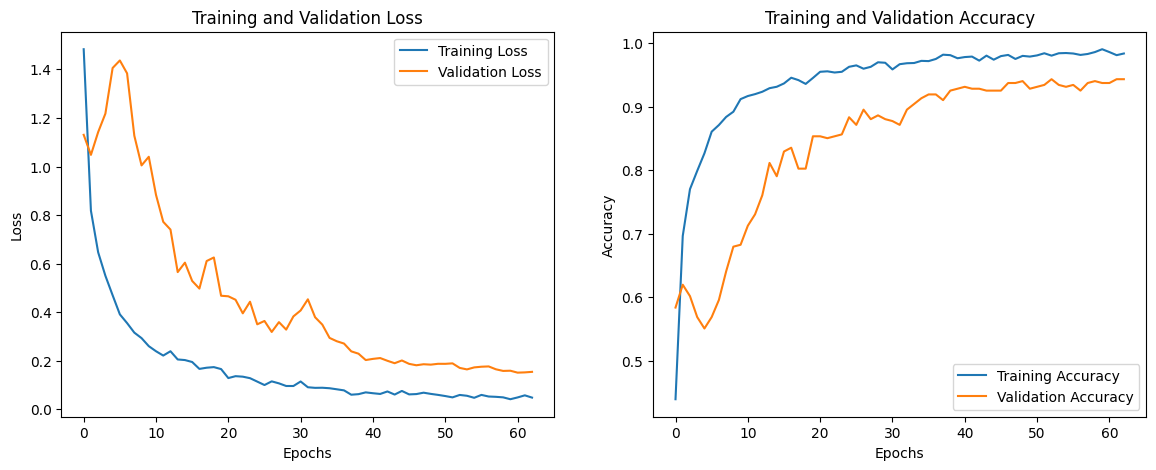

<Figure size 640x480 with 0 Axes>

In [134]:
def plot_graph(model_values):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(model_values.history['loss'], label='Training Loss')
    plt.plot(model_values.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(model_values.history['accuracy'], label='Training Accuracy')
    plt.plot(model_values.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

# Plot results
plot_graph(history)
plt.savefig('Graphs', dpi=1400)


In [145]:
def evaluate_model(model, val_generator):
    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())
    
    # Predictions
    predictions = model.predict(val_generator, steps=len(val_generator))
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    colors = ["white", "royalblue"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('Confusion_Matrix.png', dpi=1400, bbox_inches='tight')
    plt.show()


7/7 [==============================] - 0s 46ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x78d5a59abaa0>


              precision    recall  f1-score   support

   cardboard       1.00      0.89      0.94        55
       glass       0.96      0.87      0.91        55
       metal       0.92      0.98      0.95        55
       paper       0.94      0.98      0.96        59
     plastic       0.91      0.95      0.93        55
       trash       0.95      0.98      0.96        55

    accuracy                           0.94       334
   macro avg       0.95      0.94      0.94       334
weighted avg       0.94      0.94      0.94       334



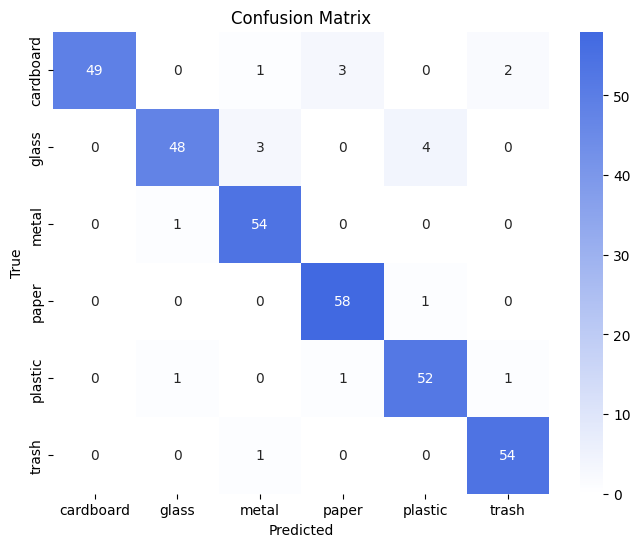

In [146]:
evaluate_model(model, valid_dataset)

In [137]:
model.save('mobilenetv2_model.h5')

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [138]:
model.save('mobilenetv2_model')

INFO:tensorflow:Assets written to: mobilenetv2_model/assets


INFO:tensorflow:Assets written to: mobilenetv2_model/assets


In [130]:
model.save_weights('mobilenetv2_weights.h5')